In [28]:
'''
    Build rectangular grid for comparison with tesselation:
'''

import pandas as pd
import numpy as np
import geopandas as gpd
import json 
import geojson
import matplotlib.pyplot as plt 

from pprint import pprint 

import pytess
from shapely.geometry import shape, Point
from descartes import PolygonPatch
import fiona 

from shapely import geometry
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Polygon, mapping
from scipy.spatial import Voronoi, voronoi_plot_2d

import shapely.geometry
import pyproj

import rasterio
import shapefile as shp
from rasterio.plot import show
from rasterstats import zonal_stats

In [29]:
# user defined functions

def getCoords(r): 
    return (Point(r[0]), Polygon(r[1]))

In [30]:
# social media data
df_weibo = pd.read_csv('../data/inLabelRegionPoints.csv')

# geojson of beijing for plotting
with open("../data/beijing.geojson") as json_file:
    json_data = geojson.load(json_file)
    
# tesselation shapefile
roi_path = "../data/18_22_100e_som_voronoi/18_22_100e_som_voronoi.shp"
ROI_shp=gpd.read_file(roi_path)
ROI_shp["Name"]= ['Feature_'+str(x) for x in range(0, len(ROI_shp))]
ROI=shp.Reader(roi_path)

In [31]:
# get corners for ROI to restrict plotting axes
maxLon, minLon = np.max(df_weibo['lon']), np.min(df_weibo['lon'])
maxLat, minLat = np.max(df_weibo['lat']), np.min(df_weibo['lat'])
corners = [(minLon, maxLat), (maxLon, maxLat), (maxLon, minLat), (minLon, minLat)]
dfCorners = pd.DataFrame(corners)
dfCorners.columns = ['lon', 'lat']

In [32]:
# get delta and stepsize to make even grid accross region
stepsize = 0.028
lon_delta = maxLon - minLon
lat_delta = maxLat - minLat

stepLat = float(lat_delta) / float(18)
stepLon = float(lon_delta) / float(22)

xs = [minLon + n*stepsize for n in range(0, 23)]
ys = [minLat + n*stepsize for n in range(0, 23)]

In [33]:
# make coordinate tuples and generate square polygons
coords = []
for i in range(len(xs)): 
    for c in range(len(ys)):
        coords.append([xs[i], ys[c]])


squares = [] 
for i in coords: 
    out = [(i[0], i[1] + stepsize), (i[0] + stepsize, i[1] + stepsize), (i[0] + stepsize, i[1]), (i[0], i[1])]
    if (i[1] + stepsize) > maxLat: 
        u = 0
    elif (i[0] + stepsize) > maxLon: 
        u = 0
    else: 
        squares.append(out)
        
        
polygons = [geometry.Polygon(i) for i in squares]

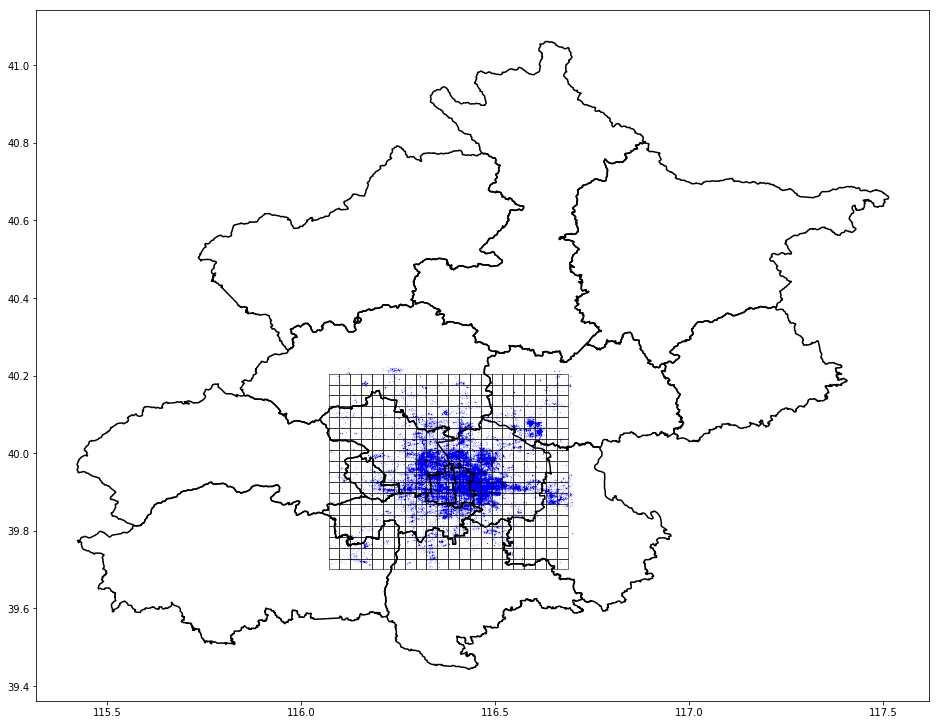

In [34]:
# plot beijing polygons fro reference
fig = plt.figure(figsize=(16,16))
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        ax = fig.gca() 
        ax.plot(x, y, color='black')
        ax.axis('scaled')
    except: 
        continue

# plot rectangular grid
for p in polygons: 
    x,y = p.exterior.xy
    ax.plot(x, y, color='black', alpha=0.7,# color='#6699cc', alpha=0.7,
        linewidth=0.75, solid_capstyle='round', zorder=2)


# plot social media data
ax.scatter(df_weibo['lon'], df_weibo['lat'], color='blue', s=0.001)

# reveal plot
plt.show() 


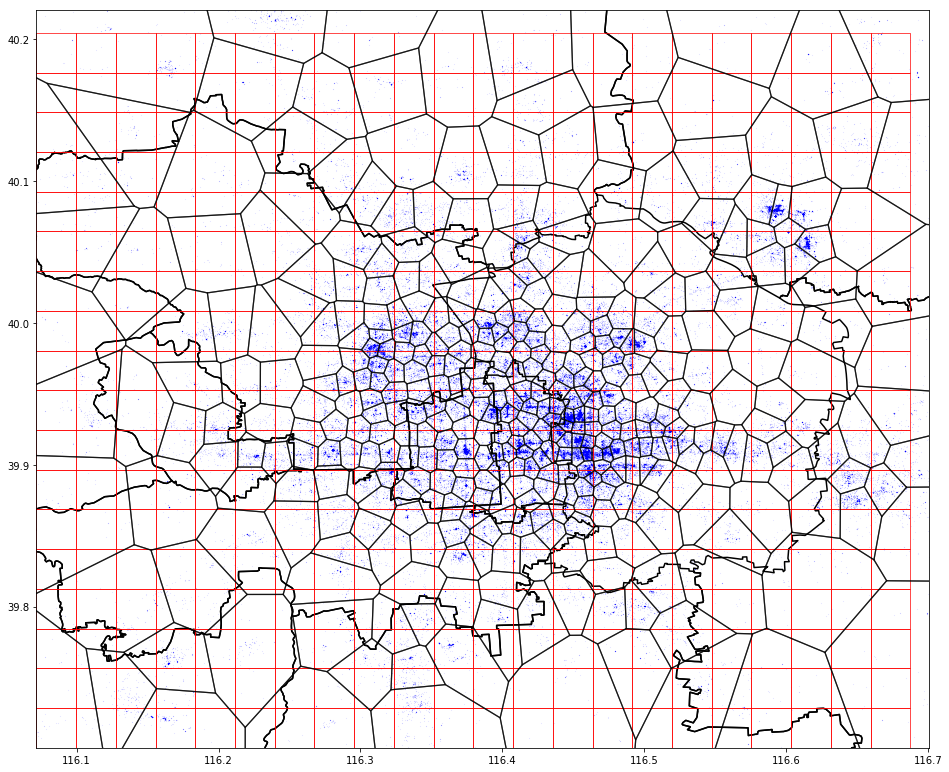

In [53]:
# plot beijing polygons fro reference
fig = plt.figure(figsize=(16,16))
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        ax = fig.gca() 
        ax.plot(x, y, color='black')
        ax.axis('scaled')
    except: 
        continue

# plot rectangular grid
for p in polygons: 
    x,y = p.exterior.xy
    ax.plot(x, y, color='red', alpha=0.7,# color='#6699cc', alpha=0.7,
        linewidth=1, solid_capstyle='round', zorder=2)

# add polygons
shapes = ROI_shp['geometry']
fig = plt.figure(figsize=(16,16))
for i in shapes: 
    x,y = i.exterior.xy
    ax.plot(x, y, color='black', alpha=0.7,# color='#6699cc', alpha=0.7,
        linewidth=1.25, solid_capstyle='round', zorder=2)


# plot social media data
ax.scatter(df_weibo['lon'], df_weibo['lat'], color='blue', s=0.001)

# limit axes to corner points of ROI
ax.set_xlim(minLon, maxLon)
ax.set_ylim(minLat, maxLat)

# reveal plot
plt.show() 


In [54]:
dfPolygon = pd.DataFrame(polygons)
dfPolygon.reset_index(inplace=True)

dfPolygon.columns = ['polygonID', 'polygon']

schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}


shape_path = '../data/regular_grid_shape/regular_grid_shape.shp'
with fiona.open(shape_path, 'w', 'ESRI Shapefile', schema) as c:
   for i in range(len(dfPolygon)): 
        r = dfPolygon.iloc[i]
        c.write({
            'geometry': mapping(r['polygon']),
            'properties': { 'id': i},
        })
